<a href="https://colab.research.google.com/github/ccrespobarreda-ctrl/TFM/blob/main/Fracturas_v2_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA available: True
Device: cuda


In [2]:
# =========================
# 1) Drive + Rutas + Checks
# =========================
from google.colab import drive
drive.mount("/content/drive")

import os, glob

# ✅ Tu estructura (según tu captura):
# Mi unidad / PROYECTOS DS / FRACTURAS /
PROJECT_ROOT = "/content/drive/MyDrive/PROYECTOS DS/FRACTURAS"

CSV_PATH = os.path.join(PROJECT_ROOT, "dataset.csv")
FRACTURED_DIR = os.path.join(PROJECT_ROOT, "Fractured")
NON_FRACTURED_DIR = os.path.join(PROJECT_ROOT, "Non_fractured")

def assert_exists(path, kind="file"):
    if kind == "file" and not os.path.isfile(path):
        raise FileNotFoundError(f"❌ No encuentro el archivo: {path}")
    if kind == "dir" and not os.path.isdir(path):
        raise FileNotFoundError(f"❌ No encuentro la carpeta: {path}")

assert_exists(CSV_PATH, "file")
assert_exists(FRACTURED_DIR, "dir")
assert_exists(NON_FRACTURED_DIR, "dir")

print("✅ CSV_PATH:", CSV_PATH)
print("✅ FRACTURED_DIR:", FRACTURED_DIR, "| n_imgs:", len(glob.glob(os.path.join(FRACTURED_DIR, "*"))))
print("✅ NON_FRACTURED_DIR:", NON_FRACTURED_DIR, "| n_imgs:", len(glob.glob(os.path.join(NON_FRACTURED_DIR, "*"))))

Mounted at /content/drive
✅ CSV_PATH: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/dataset.csv
✅ FRACTURED_DIR: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/Fractured | n_imgs: 724
✅ NON_FRACTURED_DIR: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/Non_fractured | n_imgs: 3373


In [ ]:
import shutil, os

LOCAL_ROOT = "/content/FRACTURAS"

if not os.path.exists(LOCAL_ROOT):  # evita copiar cada vez
    shutil.copytree(PROJECT_ROOT, LOCAL_ROOT)

print("Copiado a:", LOCAL_ROOT)

CSV_PATH = os.path.join(LOCAL_ROOT, "dataset.csv")
FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Fractured")
NON_FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Non_fractured")

Copiado a: /content/FRACTURAS


In [ ]:
# =========================
# 0) GPU
# =========================
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Device:", device)

# =========================
# 1) Drive + rutas
# =========================
from google.colab import drive
drive.mount("/content/drive")

import os, glob, shutil
import pandas as pd

PROJECT_ROOT = "/content/drive/MyDrive/PROYECTOS DS/FRACTURAS"
LOCAL_ROOT   = "/content/FRACTURAS"

def assert_exists(path, kind="file"):
    if kind == "file" and not os.path.isfile(path):
        raise FileNotFoundError(f"❌ No encuentro el archivo: {path}")
    if kind == "dir" and not os.path.isdir(path):
        raise FileNotFoundError(f"❌ No encuentro la carpeta: {path}")

# Checks en Drive
CSV_DRIVE = os.path.join(PROJECT_ROOT, "dataset.csv")
FRACT_DRIVE = os.path.join(PROJECT_ROOT, "Fractured")
NONF_DRIVE  = os.path.join(PROJECT_ROOT, "Non_fractured")

assert_exists(CSV_DRIVE, "file")
assert_exists(FRACT_DRIVE, "dir")
assert_exists(NONF_DRIVE, "dir")

print("✅ DRIVE CSV:", CSV_DRIVE)
print("✅ DRIVE Fractured n:", len(glob.glob(os.path.join(FRACT_DRIVE, "*"))))
print("✅ DRIVE Non_fractured n:", len(glob.glob(os.path.join(NONF_DRIVE, "*"))))

# Copia a local (para velocidad)
if not os.path.exists(LOCAL_ROOT):
    shutil.copytree(PROJECT_ROOT, LOCAL_ROOT)
print("✅ Copiado/Disponible en:", LOCAL_ROOT)

# Rutas locales definitivas
CSV_PATH = os.path.join(LOCAL_ROOT, "dataset.csv")
FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Fractured")
NON_FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Non_fractured")

assert_exists(CSV_PATH, "file")
assert_exists(FRACTURED_DIR, "dir")
assert_exists(NON_FRACTURED_DIR, "dir")

print("✅ LOCAL CSV:", CSV_PATH)
print("✅ LOCAL Fractured n:", len(glob.glob(os.path.join(FRACTURED_DIR, "*"))))
print("✅ LOCAL Non_fractured n:", len(glob.glob(os.path.join(NON_FRACTURED_DIR, "*"))))

# =========================
# 2) Cargar CSV + construir paths
# =========================
df = pd.read_csv(CSV_PATH)

IMAGE_COL = "image_id"
LABEL_COL = "fractured"   # 0/1
df[LABEL_COL] = df[LABEL_COL].astype(int)

def build_path(row):
    fname = str(row[IMAGE_COL])
    base_dir = FRACTURED_DIR if row[LABEL_COL] == 1 else NON_FRACTURED_DIR
    return os.path.join(base_dir, fname)

df["img_path"] = df.apply(build_path, axis=1)

# Filtrar imágenes que no existen (ANTES del split)
exists_mask = df["img_path"].apply(os.path.exists)
missing = (~exists_mask).sum()
if missing:
    print(f"⚠️ Filtrando {missing} filas con imágenes inexistentes.")
df = df.loc[exists_mask].reset_index(drop=True)

print("✅ Total filas válidas:", len(df))
print("✅ %fractura:", df[LABEL_COL].mean())

# =========================
# 3) Split estratificado
# =========================
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[LABEL_COL]
)

print("Train:", train_df.shape, "Val:", val_df.shape)
print("Train counts:\n", train_df[LABEL_COL].value_counts())
print("Val counts:\n", val_df[LABEL_COL].value_counts())

# =========================
# 4) Dataset + DataLoaders
# =========================
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

ImageFile.LOAD_TRUNCATED_IMAGES = True

IMG_SIZE = 224
BATCH_SIZE = 32

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class FractureDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "img_path"]
        y = int(self.df.loc[idx, LABEL_COL])

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.float32)

train_ds = FractureDataset(train_df, transform=train_tfms)
val_ds   = FractureDataset(val_df, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Test batch
x, y = next(iter(train_loader))
print("✅ Batch:", x.shape, y.shape, "y unique:", torch.unique(y))

# =========================
# 5) Modelo + entrenamiento
# =========================
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def build_model(model_name="efficientnet_b0"):
    if model_name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
        return model
    raise ValueError("Modelo no soportado")

MODEL_NAME = "efficientnet_b0"
model = build_model(MODEL_NAME).to(device)

# pos_weight con el train REAL (ya filtrado)
n_pos = int((train_df[LABEL_COL] == 1).sum())
n_neg = int((train_df[LABEL_COL] == 0).sum())
pos_weight = torch.tensor([n_neg / max(1, n_pos)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def compute_metrics(logits, y_true, threshold=0.5):
    probs = torch.sigmoid(logits).detach().cpu()
    y = y_true.detach().cpu().int()
    y_pred = (probs >= threshold).int()

    tp = ((y_pred == 1) & (y == 1)).sum().item()
    tn = ((y_pred == 0) & (y == 0)).sum().item()
    fp = ((y_pred == 1) & (y == 0)).sum().item()
    fn = ((y_pred == 0) & (y == 1)).sum().item()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    recall = tp / max(1, (tp + fn))
    spec = tn / max(1, (tn + fp))
    return {"accuracy": acc, "recall": recall, "specificity": spec}

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_logits, all_y = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits.detach())
        all_y.append(yb.detach())

    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(torch.cat(all_logits), torch.cat(all_y))
    return avg_loss, metrics

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_logits, all_y = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits)
        all_y.append(yb)

    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(torch.cat(all_logits), torch.cat(all_y))
    return avg_loss, metrics

best_recall = -1.0
best_epoch = -1

for epoch in range(1, 6):
    tr_loss, tr_m = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_m = evaluate(model, val_loader, criterion, device)

    print(
        f"Epoch {epoch} | "
        f"Train loss {tr_loss:.4f} acc {tr_m['accuracy']:.3f} rec {tr_m['recall']:.3f} | "
        f"Val loss {va_loss:.4f} acc {va_m['accuracy']:.3f} rec {va_m['recall']:.3f}"
    )

    if va_m["recall"] > best_recall:
        best_recall = float(va_m["recall"])
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_name": MODEL_NAME,
            "model_state_dict": model.state_dict(),
            "recall": float(va_m["recall"]),
            "accuracy": float(va_m["accuracy"]),
            "val_loss": float(va_loss),
        }, "best_model_recall.pt")
        print(f"✅ Nuevo mejor guardado: epoch={epoch} val_recall={best_recall:.3f}")

print(f"\n🏁 Mejor epoch por recall: {best_epoch} (val_recall={best_recall:.3f})")

CUDA available: True
Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ DRIVE CSV: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/dataset.csv
✅ DRIVE Fractured n: 724
✅ DRIVE Non_fractured n: 3373
✅ Copiado/Disponible en: /content/FRACTURAS
✅ LOCAL CSV: /content/FRACTURAS/dataset.csv
✅ LOCAL Fractured n: 724
✅ LOCAL Non_fractured n: 3373
✅ Total filas válidas: 4083
✅ %fractura: 0.17560617193240263
Train: (3266, 14) Val: (817, 14)
Train counts:
 fractured
0    2692
1     574
Name: count, dtype: int64
Val counts:
 fractured
0    674
1    143
Name: count, dtype: int64
✅ Batch: torch.Size([32, 3, 224, 224]) torch.Size([32]) y unique: tensor([0., 1.])
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 238MB/s]


Epoch 1 | Train loss 0.8745 acc 0.703 rec 0.765 | Val loss 0.8298 acc 0.858 rec 0.587
✅ Nuevo mejor guardado: epoch=1 val_recall=0.587
Epoch 2 | Train loss 0.6785 acc 0.818 rec 0.821 | Val loss 0.6765 acc 0.781 rec 0.818
✅ Nuevo mejor guardado: epoch=2 val_recall=0.818
Epoch 3 | Train loss 0.5719 acc 0.857 rec 0.843 | Val loss 0.6927 acc 0.836 rec 0.783
Epoch 4 | Train loss 0.4809 acc 0.885 rec 0.889 | Val loss 0.7556 acc 0.798 rec 0.797
Epoch 5 | Train loss 0.4614 acc 0.886 rec 0.885 | Val loss 0.7854 acc 0.863 rec 0.762

🏁 Mejor epoch por recall: 2 (val_recall=0.818)


In [ ]:
#Medir AUC en validación (muy importante por desbalanceo)

import numpy as np
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def get_probs_and_labels(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        probs_all.append(probs.detach().cpu())
        y_all.append(y.detach().cpu())
    probs_all = torch.cat(probs_all).numpy()
    y_all = torch.cat(y_all).numpy().astype(int)
    return probs_all, y_all

probs, y_true = get_probs_and_labels(model, val_loader, device)

auc = roc_auc_score(y_true, probs) if len(np.unique(y_true)) == 2 else float("nan")
print(f"✅ Val AUC: {auc:.4f}")

✅ Val AUC: 0.8961


In [ ]:
# Elegir el mejor threshold (0.3–0.9) para mi objetivo clínico

from sklearn.metrics import confusion_matrix

def metrics_for_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    precision = tp / max(1, (tp + fp))
    recall = tp / max(1, (tp + fn))
    specificity = tn / max(1, (tn + fp))
    f1 = (2 * precision * recall) / max(1e-12, (precision + recall))

    return {"thr": thr, "acc": acc, "precision": precision, "recall": recall,
            "specificity": specificity, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

thresholds = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = [metrics_for_threshold(probs, y_true, t) for t in thresholds]

# Ordenar por recall (prioridad clínica)
results_sorted = sorted(results, key=lambda d: d["recall"], reverse=True)

print("\n=== Resultados por threshold (ordenado por RECALL) ===")
for r in results_sorted:
    print(f"thr={r['thr']:.1f} | rec={r['recall']:.3f} spec={r['specificity']:.3f} "
          f"acc={r['acc']:.3f} f1={r['f1']:.3f} | TP={r['tp']} FP={r['fp']} FN={r['fn']}")


=== Resultados por threshold (ordenado por RECALL) ===
thr=0.3 | rec=0.783 spec=0.831 acc=0.823 f1=0.607 | TP=112 FP=114 FN=31
thr=0.4 | rec=0.776 spec=0.859 acc=0.845 f1=0.636 | TP=111 FP=95 FN=32
thr=0.5 | rec=0.762 spec=0.884 acc=0.863 f1=0.661 | TP=109 FP=78 FN=34
thr=0.6 | rec=0.713 spec=0.904 acc=0.870 f1=0.658 | TP=102 FP=65 FN=41
thr=0.7 | rec=0.671 spec=0.921 acc=0.878 f1=0.658 | TP=96 FP=53 FN=47
thr=0.8 | rec=0.650 spec=0.942 acc=0.891 f1=0.676 | TP=93 FP=39 FN=50
thr=0.9 | rec=0.545 spec=0.961 acc=0.889 f1=0.632 | TP=78 FP=26 FN=65


In [ ]:
# Elegir threshold con una restricción clínica spec ≥ 0.80

import numpy as np

thresholds = np.linspace(0.05, 0.95, 91)  # paso 0.01 aprox
results = [metrics_for_threshold(probs, y_true, float(t)) for t in thresholds]

min_spec = 0.80
candidates = [r for r in results if r["specificity"] >= min_spec]
best = max(candidates, key=lambda r: r["recall"])

print("Mejor con spec>=", min_spec, "=>",
      f"thr={best['thr']:.2f} rec={best['recall']:.3f} spec={best['specificity']:.3f} "
      f"TP={best['tp']} FP={best['fp']} FN={best['fn']}")

Mejor con spec>= 0.8 => thr=0.26 rec=0.783 spec=0.807 TP=112 FP=130 FN=31


In [ ]:
# Calcula PR-AUC (buena medida para desbalanceo)

from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_true, probs)
print(f"✅ Val PR-AUC (Average Precision): {pr_auc:.4f}")


✅ Val PR-AUC (Average Precision): 0.7358


In [ ]:
# eporta Recall@Spec≥ 0.80, 0.85, 0.90, 0.95

def best_recall_at_min_spec(results, min_spec):
    candidates = [r for r in results if r["specificity"] >= min_spec]
    if not candidates:
        return None
    best = max(candidates, key=lambda r: r["recall"])
    return best

for min_spec in [0.80, 0.85, 0.90, 0.95]:
    best = best_recall_at_min_spec(results, min_spec)
    if best is None:
        print(f"Spec≥{min_spec:.2f}: no hay thresholds que cumplan")
    else:
        print(
            f"✅ Recall@Spec≥{min_spec:.2f}: "
            f"thr={best['thr']:.2f} rec={best['recall']:.3f} spec={best['specificity']:.3f} "
            f"TP={best['tp']} FP={best['fp']} FN={best['fn']}"
        )


✅ Recall@Spec≥0.80: thr=0.26 rec=0.783 spec=0.807 TP=112 FP=130 FN=31
✅ Recall@Spec≥0.85: thr=0.35 rec=0.783 spec=0.850 TP=112 FP=101 FN=31
✅ Recall@Spec≥0.90: thr=0.59 rec=0.713 spec=0.901 TP=102 FP=67 FN=41
✅ Recall@Spec≥0.95: thr=0.84 rec=0.622 spec=0.954 TP=89 FP=31 FN=54


In [ ]:
# Definir test_df
from sklearn.model_selection import train_test_split

# 1) Train vs temp (val+test)
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[LABEL_COL]
)

# 2) Val vs test
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df[LABEL_COL]
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 3266
Val: 408
Test: 409


In [ ]:
class FractureDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "img_path"]
        y = int(self.df.loc[idx, LABEL_COL])

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.float32)

In [ ]:
# Crear test_loader

test_ds = FractureDataset(test_df, transform=val_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
# Obtener probabilidades en TEST
probs_test, y_test = get_probs_and_labels(model, test_loader, device)

In [ ]:
# Métricas finales en TEST (con threshold fijo)

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score
import numpy as np

best_thr = 0.48  # ← el que elegiste en validation

y_pred_test = (probs_test >= best_thr).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0,1]).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * precision * recall / (precision + recall)

roc_auc = roc_auc_score(y_test, probs_test)
pr_auc = average_precision_score(y_test, probs_test)

print("\n===== TEST RESULTS =====")
print(f"Threshold: {best_thr}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC: {pr_auc:.3f}")
print("\nConfusion Matrix:")
print(f"TN={tn}  FP={fp}")
print(f"FN={fn}  TP={tp}")


===== TEST RESULTS =====
Threshold: 0.48
Accuracy: 0.856
Recall (Sensitivity): 0.778
Specificity: 0.872
Precision: 0.566
F1-score: 0.655
ROC-AUC: 0.882
PR-AUC: 0.700

Confusion Matrix:
TN=294  FP=43
FN=16  TP=56


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = (probs >= best_thr).astype(int)
print(confusion_matrix(y_true, y_pred))

[[592  82]
 [ 34 109]]


In [ ]:
# Guardar el modelo + threshold (y metadatos)

MODEL_NAME = "efficientnet_b0"   # el que usaste
FINAL_THR = 0.48                # el threshold elegido en VAL para spec>=0.80

torch.save({
    "model_name": MODEL_NAME,
    "model_state_dict": model.state_dict(),
    "threshold": FINAL_THR,
    "img_size": 224,
    "note": "Threshold chosen on VAL to maximize recall with spec>=0.80"
}, "fracture_model_final.pt")

print("✅ Guardado: fracture_model_final.pt (con threshold)")

✅ Guardado: fracture_model_final.pt (con threshold)


In [ ]:
# Cargarlo y usarlo para predecir una radiografía

import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image

def load_fracture_model(ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)

    if ckpt["model_name"] == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
        model.load_state_dict(ckpt["model_state_dict"])
        model.to(device).eval()

        # preprocess recomendado por los pesos (si estás usando el pipeline de weights)
        preprocess = weights.transforms()

    else:
        raise ValueError("Modelo no soportado en este loader")

    threshold = float(ckpt["threshold"])
    return model, preprocess, threshold

model2, preprocess2, thr2 = load_fracture_model("fracture_model_final.pt", device)
print("✅ Cargado. Threshold:", thr2)

✅ Cargado. Threshold: 0.48


In [ ]:
# Función de inferencia (imagen → prob + predicción)

@torch.no_grad()
def predict_fracture(image_path, model, preprocess, device, threshold):
    img = Image.open(image_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)     # [1,3,H,W]
    logit = model(x).squeeze(1)                     # [1]
    prob = torch.sigmoid(logit).item()
    pred = int(prob >= threshold)
    return prob, pred

# Ejemplo:
img_path = "/content/FRACTURAS/Non_fractured/IMG0000375.jpg"  # cambia por una tuya
prob, pred = predict_fracture(img_path, model2, preprocess2, device, thr2)

print("Prob fractura:", round(prob, 4))
print("Pred:", "FRACTURA" if pred == 1 else "NO FRACTURA")

Prob fractura: 0.3654
Pred: NO FRACTURA


FN en TEST: 16

Top FN (más cerca del threshold):
                                        img_path      prob  fracture_count  \
220  /content/FRACTURAS/Fractured/IMG0002347.jpg  0.255887               1   
171  /content/FRACTURAS/Fractured/IMG0002466.jpg  0.228367               1   
196  /content/FRACTURAS/Fractured/IMG0001933.jpg  0.222823               1   
139  /content/FRACTURAS/Fractured/IMG0002650.jpg  0.197852               1   
284  /content/FRACTURAS/Fractured/IMG0001964.jpg  0.185524               1   
210  /content/FRACTURAS/Fractured/IMG0003297.jpg  0.158326               1   
101  /content/FRACTURAS/Fractured/IMG0002180.jpg  0.152436               1   
331  /content/FRACTURAS/Fractured/IMG0003626.jpg  0.140714               1   
42   /content/FRACTURAS/Fractured/IMG0002627.jpg  0.073639               1   
122  /content/FRACTURAS/Fractured/IMG0001123.jpg  0.050310               2   
58   /content/FRACTURAS/Fractured/IMG0002105.jpg  0.049205               1   
72   /content/

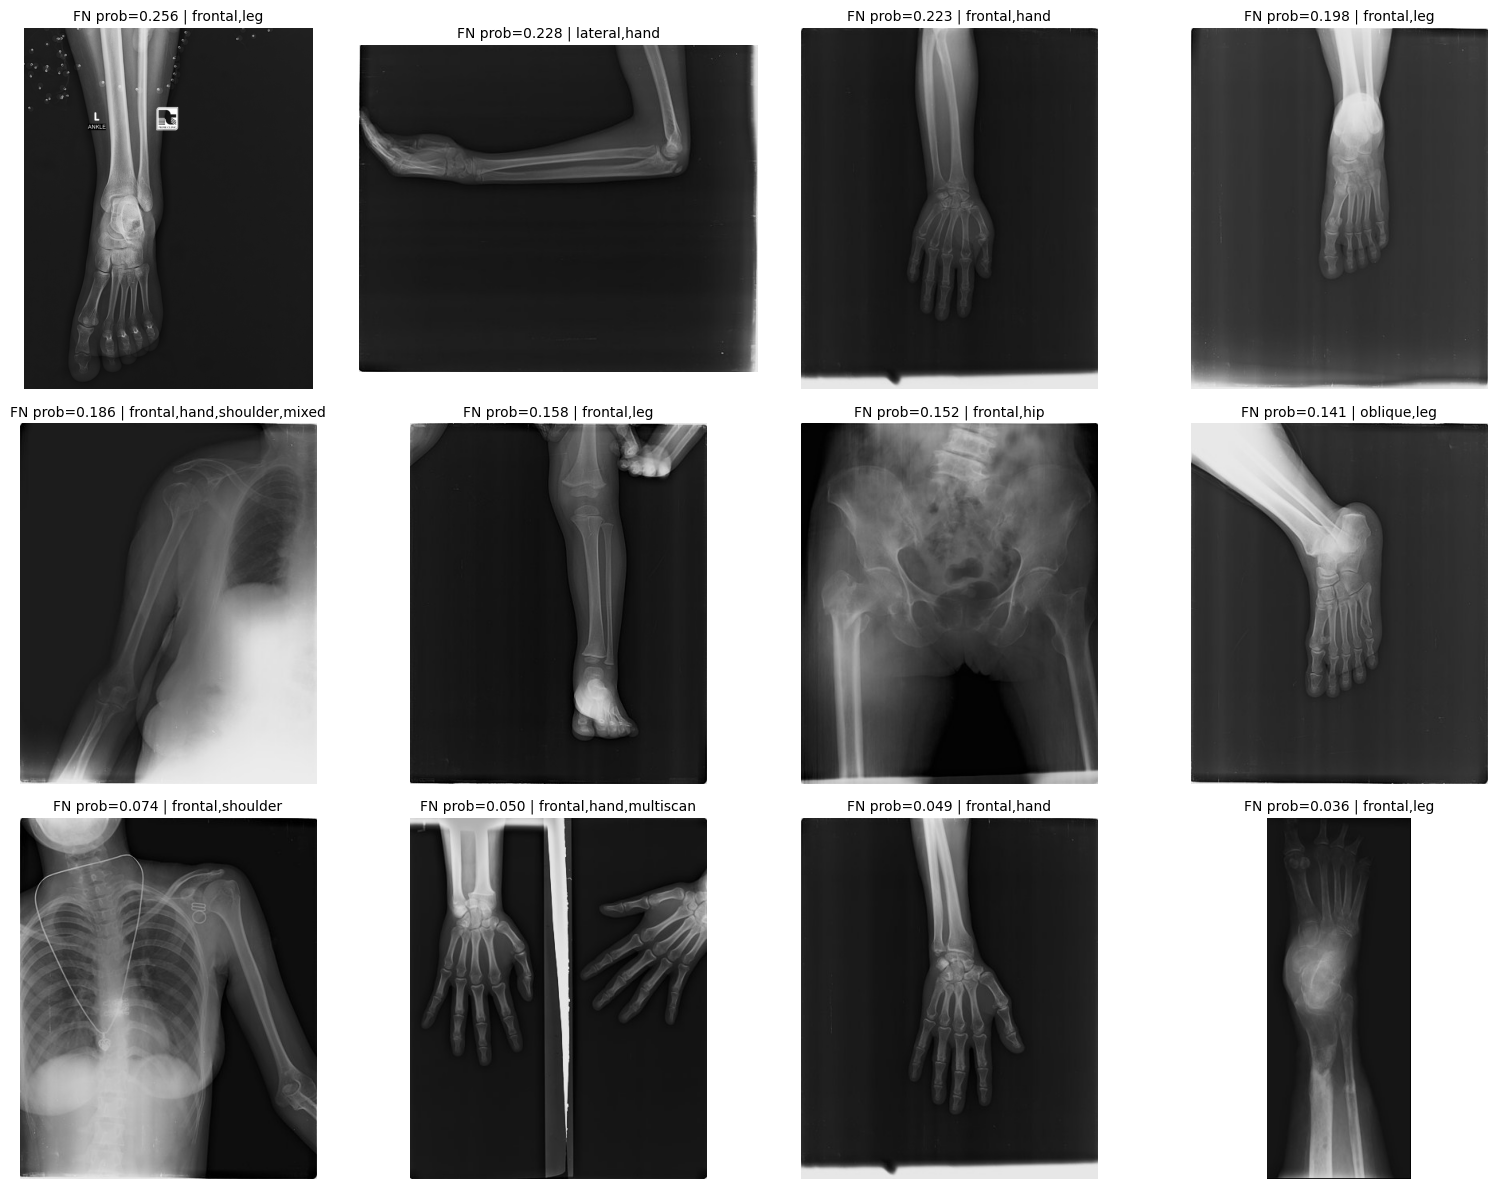

In [ ]:
# Analizar los 13 FN

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

@torch.no_grad()
def get_probs_labels_paths(model, df, loader, device):
    """
    Devuelve probs, y_true y los paths en el mismo orden que el DataLoader.
    Asume que el Dataset usa df.reset_index(drop=True) internamente (como tu FractureDataset simple).
    """
    model.eval()
    probs_all, y_all = [], []

    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
        y_all.append(yb.detach().cpu().numpy())

    probs_all = np.concatenate(probs_all)
    y_all = np.concatenate(y_all).astype(int)

    # ⚠️ Importante: el orden del loader corresponde a df reseteado (si shuffle=False)
    paths = df.reset_index(drop=True)["img_path"].tolist()

    assert len(paths) == len(y_all) == len(probs_all), "Longitudes no coinciden (revisa shuffle=False y el Dataset)."
    return probs_all, y_all, paths


def show_fn_images(fn_rows, n=12, cols=4):
    n = min(n, len(fn_rows))
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    for i in range(n):
        r = fn_rows.iloc[i]
        img_path = r["img_path"]
        prob = r["prob"]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print("No pude abrir:", img_path, "Error:", e)
            continue

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.axis("off")

        # título con prob y (si existen) pistas de columnas
        extras = []
        for c in ["frontal", "lateral", "oblique", "hand", "leg", "hip", "shoulder", "mixed", "hardware", "multiscan"]:
            if c in r.index and int(r[c]) == 1:
                extras.append(c)

        extra_txt = (" | " + ",".join(extras)) if extras else ""
        ax.set_title(f"FN prob={prob:.3f}{extra_txt}", fontsize=10)

    plt.tight_layout()
    plt.show()


# ====== USO ======
best_thr = 0.48  # el threshold fijado en VAL (spec>=0.80), el que ya estabas usando

# Asegúrate de que test_loader está creado con shuffle=False
probs_test, y_test, paths_test = get_probs_labels_paths(model, test_df, test_loader, device)

y_pred_test = (probs_test >= best_thr).astype(int)

fn_mask = (y_test == 1) & (y_pred_test == 0)
fn_idx = np.where(fn_mask)[0]
print("FN en TEST:", len(fn_idx))

# Crear un dataframe con info de FN para inspección
fn_rows = test_df.reset_index(drop=True).iloc[fn_idx].copy()
fn_rows["prob"] = probs_test[fn_idx]

# Ordenar FN por prob (las más “cerca” del threshold primero o las más bajas)
fn_rows_sorted = fn_rows.sort_values("prob", ascending=False)

print("\nTop FN (más cerca del threshold):")
cols_to_show = ["img_path", "prob"]
for c in ["fracture_count", "frontal", "lateral", "oblique", "hand", "leg", "hip", "shoulder", "hardware", "multiscan"]:
    if c in fn_rows_sorted.columns:
        cols_to_show.append(c)
print(fn_rows_sorted[cols_to_show].head(12))

# Mostrar imágenes FN
show_fn_images(fn_rows_sorted, n=12, cols=4)

In [ ]:
# 🔁 Re-crear train_df si Colab se reinició
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[LABEL_COL]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df[LABEL_COL]
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 3266
Val: 408
Test: 409


In [ ]:
# WeightedRandomSampler (mejor “quick win” para recall)
# Sube recall porque el modelo ve más positivos por época


from torch.utils.data import WeightedRandomSampler
import numpy as np

# OJO: usa train_ds (no val/test)
y_train = train_df.reset_index(drop=True)[LABEL_COL].values.astype(int)

class_counts = np.bincount(y_train)  # [n_neg, n_pos]
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]  # peso por muestra

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,      # ✅ en vez de shuffle=True
    num_workers=2,
    pin_memory=True
)

print("✅ Sampler listo. class_counts:", class_counts, "class_weights:", class_weights)


✅ Sampler listo. class_counts: [2692  574] class_weights: [0.00037147 0.00174216]


In [ ]:
# Entrenamiento + evaluación VAL + evaluación TEST

import os
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import average_precision_score, confusion_matrix

# -------------------------
# Métricas y helpers
# -------------------------
@torch.no_grad()
def predict_probs(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
        y_all.append(yb.detach().cpu().numpy())
    probs_all = np.concatenate(probs_all)
    y_all = np.concatenate(y_all).astype(int)
    return probs_all, y_all

def metrics_at_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    precision = tp / max(1, (tp + fp))
    recall = tp / max(1, (tp + fn))
    spec = tn / max(1, (tn + fp))
    f1 = (2 * precision * recall) / max(1e-12, (precision + recall))
    return {"thr": float(thr), "acc": acc, "precision": precision, "recall": recall,
            "specificity": spec, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

def best_threshold_for_min_spec(probs, y_true, min_spec=0.80):
    thresholds = np.linspace(0.05, 0.95, 181)  # step 0.005 aprox
    results = [metrics_at_threshold(probs, y_true, t) for t in thresholds]
    candidates = [r for r in results if r["specificity"] >= min_spec]
    if not candidates:
        return None
    best = max(candidates, key=lambda r: r["recall"])
    return best

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


# -------------------------
# (Re)definir criterion con pos_weight usando TRAIN actual
# -------------------------
n_pos = int((train_df[LABEL_COL] == 1).sum())
n_neg = int((train_df[LABEL_COL] == 0).sum())
pos_weight = torch.tensor([n_neg / max(1, n_pos)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizador (puedes mantener el tuyo)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 5
best_val_recall = -1.0
best_ckpt_path = "best_model_sampler_valrec.pt"

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss = eval_loss(model, val_loader, criterion, device)

    # Probabilidades y métricas en VAL con threshold 0.5 (solo informativo)
    probs_val, y_val = predict_probs(model, val_loader, device)
    m05 = metrics_at_threshold(probs_val, y_val, 0.50)
    pr_auc_val = average_precision_score(y_val, probs_val)

    print(
        f"Epoch {epoch} | "
        f"Train loss {tr_loss:.4f} | Val loss {va_loss:.4f} | "
        f"Val PR-AUC {pr_auc_val:.3f} | Val rec@0.5 {m05['recall']:.3f} spec@0.5 {m05['specificity']:.3f}"
    )

    # guardamos el mejor por RECALL en VAL (con thr=0.5 solo para selección rápida)
    if m05["recall"] > best_val_recall:
        best_val_recall = float(m05["recall"])
        torch.save({"model_state_dict": model.state_dict()}, best_ckpt_path)
        print(f"✅ Guardado mejor (por recall@0.5 en VAL): {best_ckpt_path}")


# -------------------------
# Cargar el mejor checkpoint y elegir threshold en VAL con spec>=0.80
# -------------------------
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

probs_val, y_val = predict_probs(model, val_loader, device)
best_val = best_threshold_for_min_spec(probs_val, y_val, min_spec=0.80)

print("\n=== VAL: Mejor threshold con spec>=0.80 ===")
print(f"thr={best_val['thr']:.3f} rec={best_val['recall']:.3f} spec={best_val['specificity']:.3f} "
      f"prec={best_val['precision']:.3f} TP={best_val['tp']} FP={best_val['fp']} FN={best_val['fn']}")
final_thr = best_val["thr"]

# -------------------------
# TEST (una sola vez) con el threshold elegido en VAL
# -------------------------
probs_test, y_test = predict_probs(model, test_loader, device)
test_metrics = metrics_at_threshold(probs_test, y_test, final_thr)
pr_auc_test = average_precision_score(y_test, probs_test)

print("\n===== TEST (1 vez) =====")
print(f"Threshold (from VAL): {final_thr:.3f}")
print(f"PR-AUC: {pr_auc_test:.3f}")
print(f"Recall: {test_metrics['recall']:.3f} | Spec: {test_metrics['specificity']:.3f} | "
      f"Acc: {test_metrics['acc']:.3f} | Prec: {test_metrics['precision']:.3f} | F1: {test_metrics['f1']:.3f}")
print(f"TN={test_metrics['tn']} FP={test_metrics['fp']} FN={test_metrics['fn']} TP={test_metrics['tp']}")


Epoch 1 | Train loss 0.4861 | Val loss 0.7065 | Val PR-AUC 0.772 | Val rec@0.5 0.818 spec@0.5 0.852
✅ Guardado mejor (por recall@0.5 en VAL): best_model_sampler_valrec.pt
Epoch 2 | Train loss 0.3335 | Val loss 0.9839 | Val PR-AUC 0.688 | Val rec@0.5 0.797 spec@0.5 0.838
Epoch 3 | Train loss 0.3742 | Val loss 0.8347 | Val PR-AUC 0.752 | Val rec@0.5 0.874 spec@0.5 0.731
✅ Guardado mejor (por recall@0.5 en VAL): best_model_sampler_valrec.pt
Epoch 4 | Train loss 0.3177 | Val loss 0.8103 | Val PR-AUC 0.780 | Val rec@0.5 0.762 spec@0.5 0.878
Epoch 5 | Train loss 0.3025 | Val loss 1.0403 | Val PR-AUC 0.759 | Val rec@0.5 0.762 spec@0.5 0.893

=== VAL: Mejor threshold con spec>=0.80 ===
thr=0.700 rec=0.832 spec=0.801 prec=0.470 TP=119 FP=134 FN=24

===== TEST (1 vez) =====
Threshold (from VAL): 0.700
PR-AUC: 0.733
Recall: 0.861 | Spec: 0.801 | Acc: 0.812 | Prec: 0.481 | F1: 0.617
TN=270 FP=67 FN=10 TP=62


In [ ]:
# Congelar este resultado como “baseline ganador”
# threshold final (0.700)

FINAL_THR = 0.700
torch.save({
    "model_name": "efficientnet_b0",
    "model_state_dict": model.state_dict(),
    "threshold": FINAL_THR,
    "note": "Trained with WeightedRandomSampler, thr chosen on VAL spec>=0.80"
}, "fracture_effb0_sampler_final.pt")
print("✅ Guardado fracture_effb0_sampler_final.pt")

✅ Guardado fracture_effb0_sampler_final.pt


In [ ]:
# Probar DenseNet121 (primero) y luego ResNet50

import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import resnet50, ResNet50_Weights

def build_model(name: str):
    if name == "densenet121":
        weights = DenseNet121_Weights.DEFAULT
        model = densenet121(weights=weights)
        model.classifier = nn.Linear(model.classifier.in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    if name == "resnet50":
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    raise ValueError("Modelo no soportado")


In [ ]:
# Recrea datasets/loaders

MODEL_NAME = "densenet121"  # o "resnet50"
model, preprocess = build_model(MODEL_NAME)
model = model.to(device)

train_ds = FractureDataset(train_df, transform=preprocess)
val_ds   = FractureDataset(val_df, transform=preprocess)
test_ds  = FractureDataset(test_df, transform=preprocess)

# mantenemos el sampler tal cual (recalc sobre train_df)
from torch.utils.data import WeightedRandomSampler, DataLoader
import numpy as np
import torch

y_train = train_df.reset_index(drop=True)[LABEL_COL].values.astype(int)
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 190MB/s]


In [ ]:
# Sanity check (para asegurarte de que DenseNet hace forward)

x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

model.eval()
with torch.no_grad():
    logits = model(x).squeeze(1)

print("✅ Batch:", x.shape, y.shape)
print("✅ Logits shape:", logits.shape)
print("✅ y unique:", torch.unique(y))


✅ Batch: torch.Size([32, 3, 224, 224]) torch.Size([32])
✅ Logits shape: torch.Size([32])
✅ y unique: tensor([0., 1.], device='cuda:0')


In [ ]:
# Entrenar + elegir threshold en VAL (spec≥0.80) + TEST (1 vez)

import os
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, average_precision_score

# -------- helpers ----------
@torch.no_grad()
def predict_probs(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
        y_all.append(yb.detach().cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(y_all).astype(int)

def metrics_at_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    precision = tp / max(1, (tp + fp))
    recall = tp / max(1, (tp + fn))
    spec = tn / max(1, (tn + fp))
    f1 = (2 * precision * recall) / max(1e-12, (precision + recall))
    return {"thr": float(thr), "acc": acc, "precision": precision, "recall": recall,
            "specificity": spec, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

def best_threshold_for_min_spec(probs, y_true, min_spec=0.80):
    thresholds = np.linspace(0.05, 0.95, 181)
    results = [metrics_at_threshold(probs, y_true, t) for t in thresholds]
    candidates = [r for r in results if r["specificity"] >= min_spec]
    if not candidates:
        return None
    return max(candidates, key=lambda r: r["recall"])

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


# -------- loss + optimizer ----------
n_pos = int((train_df[LABEL_COL] == 1).sum())
n_neg = int((train_df[LABEL_COL] == 0).sum())
pos_weight = torch.tensor([n_neg / max(1, n_pos)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 5
best_val_recall05 = -1.0
best_ckpt_path = f"best_{MODEL_NAME}_sampler_valrec.pt"

# -------- train loop ----------
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss = eval_loss(model, val_loader, criterion, device)

    probs_val, y_val = predict_probs(model, val_loader, device)
    pr_auc_val = average_precision_score(y_val, probs_val)
    m05 = metrics_at_threshold(probs_val, y_val, 0.50)

    print(
        f"Epoch {epoch} | "
        f"Train loss {tr_loss:.4f} | Val loss {va_loss:.4f} | "
        f"Val PR-AUC {pr_auc_val:.3f} | Val rec@0.5 {m05['recall']:.3f} spec@0.5 {m05['specificity']:.3f}"
    )

    if m05["recall"] > best_val_recall05:
        best_val_recall05 = float(m05["recall"])
        torch.save({"model_state_dict": model.state_dict()}, best_ckpt_path)
        print(f"✅ Guardado mejor (por recall@0.5 en VAL): {best_ckpt_path}")

# -------- pick thr on VAL with spec>=0.80 ----------
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

probs_val, y_val = predict_probs(model, val_loader, device)
best_val = best_threshold_for_min_spec(probs_val, y_val, min_spec=0.80)

print("\n=== VAL: Mejor threshold con spec>=0.80 ===")
print(f"thr={best_val['thr']:.3f} rec={best_val['recall']:.3f} spec={best_val['specificity']:.3f} "
      f"prec={best_val['precision']:.3f} TP={best_val['tp']} FP={best_val['fp']} FN={best_val['fn']}")

final_thr = best_val["thr"]

# -------- TEST once ----------
probs_test, y_test = predict_probs(model, test_loader, device)
pr_auc_test = average_precision_score(y_test, probs_test)
test_m = metrics_at_threshold(probs_test, y_test, final_thr)

print("\n===== TEST (1 vez) =====")
print(f"Modelo: {MODEL_NAME}")
print(f"Threshold (from VAL): {final_thr:.3f}")
print(f"PR-AUC: {pr_auc_test:.3f}")
print(f"Recall: {test_m['recall']:.3f} | Spec: {test_m['specificity']:.3f} | "
      f"Acc: {test_m['acc']:.3f} | Prec: {test_m['precision']:.3f} | F1: {test_m['f1']:.3f}")
print(f"TN={test_m['tn']} FP={test_m['fp']} FN={test_m['fn']} TP={test_m['tp']}")


Epoch 1 | Train loss 0.7743 | Val loss 1.0095 | Val PR-AUC 0.567 | Val rec@0.5 0.915 spec@0.5 0.469
✅ Guardado mejor (por recall@0.5 en VAL): best_densenet121_sampler_valrec.pt
Epoch 2 | Train loss 0.5401 | Val loss 0.9429 | Val PR-AUC 0.750 | Val rec@0.5 0.831 spec@0.5 0.641
Epoch 3 | Train loss 0.4159 | Val loss 0.8725 | Val PR-AUC 0.716 | Val rec@0.5 0.732 spec@0.5 0.849
Epoch 4 | Train loss 0.2312 | Val loss 0.8927 | Val PR-AUC 0.725 | Val rec@0.5 0.746 spec@0.5 0.855
Epoch 5 | Train loss 0.2676 | Val loss 0.9689 | Val PR-AUC 0.667 | Val rec@0.5 0.775 spec@0.5 0.852

=== VAL: Mejor threshold con spec>=0.80 ===
thr=0.790 rec=0.690 spec=0.801 prec=0.422 TP=49 FP=67 FN=22

===== TEST (1 vez) =====
Modelo: densenet121
Threshold (from VAL): 0.790
PR-AUC: 0.545
Recall: 0.694 | Spec: 0.813 | Acc: 0.792 | Prec: 0.442 | F1: 0.541
TN=274 FP=63 FN=22 TP=50


In [ ]:
# Peores resultados, me quedo con EfficientNet-B0 + sampler (por ahora)
# DenseNet121 no merece la pena
# Lo guardo

FINAL_MODEL_NAME = "efficientnet_b0"
FINAL_THR = 0.700  # el que te salió con effnet+sampler

torch.save({
    "model_name": FINAL_MODEL_NAME,
    "model_state_dict": model_effnet.state_dict() if "model_effnet" in globals() else model.state_dict(),
    "threshold": FINAL_THR,
    "notes": "WeightedRandomSampler. Threshold chosen on VAL with spec>=0.80. Do not tune on TEST."
}, "fracture_best_model.pt")

print("✅ Guardado fracture_best_model.pt con threshold")

✅ Guardado fracture_best_model.pt con threshold


In [ ]:
# Imports base y build_model (ResNet50 incluido)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, average_precision_score

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights  # por si quieres comparar


In [ ]:
def build_model(name: str):
    if name == "resnet50":
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    if name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    raise ValueError("Modelo no soportado")


In [ ]:
# Crear loaders (sampler en train, shuffle=False en val/test)

def make_loaders(train_df, val_df, test_df, preprocess, batch_size=32, num_workers=2):
    # Datasets con preprocess del modelo
    train_ds = FractureDataset(train_df, transform=preprocess)
    val_ds   = FractureDataset(val_df, transform=preprocess)
    test_ds  = FractureDataset(test_df, transform=preprocess)

    # WeightedRandomSampler (train)
    y_train = train_df.reset_index(drop=True)[LABEL_COL].values.astype(int)
    class_counts = np.bincount(y_train)  # [n_neg, n_pos]
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_train]

    sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, class_counts


In [ ]:
# Métricas + threshold óptimo con restricción de spec

@torch.no_grad()
def predict_probs(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
        y_all.append(yb.detach().cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(y_all).astype(int)

def metrics_at_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    precision = tp / max(1, (tp + fp))
    recall = tp / max(1, (tp + fn))
    spec = tn / max(1, (tn + fp))
    f1 = (2 * precision * recall) / max(1e-12, (precision + recall))

    return {"thr": float(thr), "acc": acc, "precision": precision, "recall": recall,
            "specificity": spec, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

def best_threshold_for_min_spec(probs, y_true, min_spec=0.80):
    thresholds = np.linspace(0.05, 0.95, 181)  # step ~0.005
    results = [metrics_at_threshold(probs, y_true, t) for t in thresholds]
    candidates = [r for r in results if r["specificity"] >= min_spec]
    if not candidates:
        return None
    return max(candidates, key=lambda r: r["recall"])


In [ ]:
# Entrenar (con opción de BCE o Focal Loss)

# Focal Loss (opcional)

class FocalLossWithLogits(nn.Module):
    """
    Focal Loss para binario usando logits (compatible con salida 1).
    alpha: peso para clase positiva (aprox como pos_weight, pero distinto concepto)
    gamma: focalización (2.0 típico)
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # targets: float 0/1
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p = torch.sigmoid(logits)
        pt = torch.where(targets == 1, p, 1 - p)  # prob del target real
        loss = (self.alpha * (1 - pt) ** self.gamma) * bce

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss


In [ ]:
# Train loop + guardado del “mejor” (por Recall@Spec≥0.80 en VAL)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


def run_experiment(
    model_name: str,
    train_df, val_df, test_df,
    batch_size=32,
    epochs=5,
    min_spec=0.80,
    use_focal=False,
    img_size_note="default_preprocess"
):
    # 1) Modelo + preprocess
    model, preprocess = build_model(model_name)
    model = model.to(device)

    # 2) Loaders + sampler
    train_loader, val_loader, test_loader, class_counts = make_loaders(
        train_df, val_df, test_df, preprocess,
        batch_size=batch_size
    )

    # 3) Loss
    n_pos = int((train_df[LABEL_COL] == 1).sum())
    n_neg = int((train_df[LABEL_COL] == 0).sum())
    pos_weight = torch.tensor([n_neg / max(1, n_pos)], dtype=torch.float32).to(device)

    if use_focal:
        # alpha se puede ajustar; lo dejo moderado
        criterion = FocalLossWithLogits(alpha=0.25, gamma=2.0)
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    # 4) Entrenamiento guardando el mejor por Recall@Spec>=min_spec en VAL
    best_ckpt_path = f"best_{model_name}_sampler_{img_size_note}_{'focal' if use_focal else 'bce'}.pt"
    best_val_recall_constrained = -1.0
    best_thr = None

    print("\n==============================")
    print(f"🚀 Experimento: {model_name} | loss={'focal' if use_focal else 'bce'} | batch={batch_size}")
    print("class_counts [neg,pos]:", class_counts)
    print("Checkpoint:", best_ckpt_path)
    print("==============================\n")

    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss = eval_loss(model, val_loader, criterion, device)

        probs_val, y_val = predict_probs(model, val_loader, device)
        pr_auc_val = average_precision_score(y_val, probs_val)

        best_val = best_threshold_for_min_spec(probs_val, y_val, min_spec=min_spec)
        if best_val is None:
            print(f"Epoch {epoch} | Train {tr_loss:.4f} | Val {va_loss:.4f} | Val PR-AUC {pr_auc_val:.3f} | "
                  f"⚠️ No hay threshold con spec>={min_spec}")
            continue

        print(
            f"Epoch {epoch} | Train {tr_loss:.4f} | Val {va_loss:.4f} | Val PR-AUC {pr_auc_val:.3f} | "
            f"VAL best@spec>={min_spec}: thr={best_val['thr']:.3f} rec={best_val['recall']:.3f} spec={best_val['specificity']:.3f}"
        )

        if best_val["recall"] > best_val_recall_constrained:
            best_val_recall_constrained = float(best_val["recall"])
            best_thr = float(best_val["thr"])
            torch.save({
                "model_name": model_name,
                "model_state_dict": model.state_dict(),
                "threshold": best_thr,
                "min_spec": min_spec,
                "use_focal": use_focal,
                "img_size_note": img_size_note,
            }, best_ckpt_path)
            print(f"✅ Nuevo mejor guardado (VAL constrained recall): rec={best_val_recall_constrained:.3f} thr={best_thr:.3f}")

    # 5) Cargar el mejor y evaluar TEST (1 vez)
    ckpt = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    final_thr = ckpt["threshold"]

    probs_test, y_test = predict_probs(model, test_loader, device)
    pr_auc_test = average_precision_score(y_test, probs_test)
    test_m = metrics_at_threshold(probs_test, y_test, final_thr)

    print("\n===== TEST (1 vez) =====")
    print(f"Modelo: {model_name} | thr(from VAL): {final_thr:.3f} | loss={'focal' if use_focal else 'bce'}")
    print(f"PR-AUC: {pr_auc_test:.3f}")
    print(f"Recall: {test_m['recall']:.3f} | Spec: {test_m['specificity']:.3f} | Acc: {test_m['acc']:.3f} | Prec: {test_m['precision']:.3f} | F1: {test_m['f1']:.3f}")
    print(f"TN={test_m['tn']} FP={test_m['fp']} FN={test_m['fn']} TP={test_m['tp']}")

    return {
        "model": model,
        "threshold": final_thr,
        "ckpt_path": best_ckpt_path,
        "test_metrics": test_m,
        "test_pr_auc": pr_auc_test
    }


In [ ]:
# Ejecutar el experimento con ResNet50

# Probar ResNet50 con tu setup actual
resnet50_result = run_experiment(
    model_name="resnet50",
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=32,   # si te da OOM, baja a 16
    epochs=5,
    min_spec=0.80,
    use_focal=False,   # primero BCE+pos_weight
    img_size_note="224"
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]



🚀 Experimento: resnet50 | loss=bce | batch=32
class_counts [neg,pos]: [2692  574]
Checkpoint: best_resnet50_sampler_224_bce.pt

Epoch 1 | Train 0.8103 | Val 0.9044 | Val PR-AUC 0.559 | VAL best@spec>=0.8: thr=0.645 rec=0.592 spec=0.810
✅ Nuevo mejor guardado (VAL constrained recall): rec=0.592 thr=0.645
Epoch 2 | Train 0.4741 | Val 0.7531 | Val PR-AUC 0.750 | VAL best@spec>=0.8: thr=0.220 rec=0.761 spec=0.807
✅ Nuevo mejor guardado (VAL constrained recall): rec=0.761 thr=0.220
Epoch 3 | Train 0.2706 | Val 0.9499 | Val PR-AUC 0.742 | VAL best@spec>=0.8: thr=0.260 rec=0.789 spec=0.804
✅ Nuevo mejor guardado (VAL constrained recall): rec=0.789 thr=0.260
Epoch 4 | Train 0.2561 | Val 0.9925 | Val PR-AUC 0.721 | VAL best@spec>=0.8: thr=0.200 rec=0.845 spec=0.804
✅ Nuevo mejor guardado (VAL constrained recall): rec=0.845 thr=0.200
Epoch 5 | Train 0.3156 | Val 0.8465 | Val PR-AUC 0.762 | VAL best@spec>=0.8: thr=0.255 rec=0.859 spec=0.801
✅ Nuevo mejor guardado (VAL constrained recall): rec=0.

In [ ]:
# Transforms “manuales” con 320 y RandomResizedCrop

from torchvision import transforms

def make_tfms(img_size=320, train=True):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),  # más zoom al hueso
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])


In [ ]:
# Correr ResNet50 (o EfficientNet) con 320 + crop

MODEL_NAME = "resnet50"  # o "efficientnet_b0"
model, _ = build_model(MODEL_NAME)
model = model.to(device)

train_tfms_320 = make_tfms(img_size=320, train=True)
val_tfms_320   = make_tfms(img_size=320, train=False)

train_ds = FractureDataset(train_df, transform=train_tfms_320)
val_ds   = FractureDataset(val_df,   transform=val_tfms_320)
test_ds  = FractureDataset(test_df,  transform=val_tfms_320)

# sampler
y_train = train_df.reset_index(drop=True)[LABEL_COL].values.astype(int)
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE_320 = 16  # suele hacer falta bajar batch con 320/384
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE_320, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE_320, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE_320, shuffle=False, num_workers=2, pin_memory=True)

# Ahora reutiliza tu bloque de entrenamiento/evaluación (o llama a run_experiment adaptándolo)


In [ ]:
# Helpers (predicción + métricas + threshold clínico)

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, average_precision_score

@torch.no_grad()
def predict_probs(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        probs_all.append(probs)
        y_all.append(yb.detach().cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(y_all).astype(int)

def metrics_at_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    precision = tp / max(1, (tp + fp))
    recall = tp / max(1, (tp + fn))          # 🔴 MÉTRICA CLAVE (no perder fracturas)
    spec = tn / max(1, (tn + fp))
    f1 = (2 * precision * recall) / max(1e-12, (precision + recall))

    return {
        "thr": float(thr),
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "specificity": spec,
        "f1": f1,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn
    }

def best_threshold_for_min_spec(probs, y_true, min_spec=0.80):
    thresholds = np.linspace(0.05, 0.95, 181)
    results = [metrics_at_threshold(probs, y_true, t) for t in thresholds]
    candidates = [r for r in results if r["specificity"] >= min_spec]

    if not candidates:
        return None

    # Elegimos el que maximiza recall cumpliendo la restricción clínica
    return max(candidates, key=lambda r: r["recall"])


In [ ]:
# Funciones de entrenamiento (reutilizables)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)


In [ ]:
# Entrenamiento + selección de threshold clínico + TEST (1 sola vez)

# ===== LOSS (importante por desbalanceo) =====
n_pos = int((train_df[LABEL_COL] == 1).sum())
n_neg = int((train_df[LABEL_COL] == 0).sum())

pos_weight = torch.tensor([n_neg / max(1, n_pos)], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 5
MIN_SPEC = 0.80  # restricción clínica
best_val_recall_constrained = -1.0

best_ckpt_path = f"best_{MODEL_NAME}_clinical.pt"
print("Checkpoint clínico:", best_ckpt_path)

# ===== TRAIN LOOP =====
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss = eval_loss(model, val_loader, criterion, device)

    probs_val, y_val = predict_probs(model, val_loader, device)
    pr_auc_val = average_precision_score(y_val, probs_val)

    best_val = best_threshold_for_min_spec(probs_val, y_val, min_spec=MIN_SPEC)

    if best_val is None:
        print(f"Epoch {epoch} | Train {tr_loss:.4f} | Val {va_loss:.4f} | ⚠️ No threshold con spec≥{MIN_SPEC}")
        continue

    print(
        f"Epoch {epoch} | "
        f"Train loss {tr_loss:.4f} | Val loss {va_loss:.4f} | "
        f"Val PR-AUC {pr_auc_val:.3f} | "
        f"VAL best (spec≥{MIN_SPEC}): thr={best_val['thr']:.3f} "
        f"rec={best_val['recall']:.3f} spec={best_val['specificity']:.3f}"
    )

    # Guardar el mejor modelo SEGÚN OBJETIVO CLÍNICO (recall bajo spec>=0.80)
    if best_val["recall"] > best_val_recall_constrained:
        best_val_recall_constrained = float(best_val["recall"])
        torch.save({
            "model_state_dict": model.state_dict(),
            "threshold": best_val["thr"],
            "val_recall": best_val["recall"],
            "val_spec": best_val["specificity"],
            "model_name": MODEL_NAME
        }, best_ckpt_path)
        print(f"✅ Nuevo mejor modelo clínico guardado (rec={best_val['recall']:.3f})")


Checkpoint clínico: best_resnet50_clinical.pt
Epoch 1 | Train loss 0.9743 | Val loss 0.9070 | Val PR-AUC 0.665 | VAL best (spec≥0.8): thr=0.765 rec=0.732 spec=0.807
✅ Nuevo mejor modelo clínico guardado (rec=0.732)
Epoch 2 | Train loss 0.8201 | Val loss 0.9858 | Val PR-AUC 0.648 | VAL best (spec≥0.8): thr=0.795 rec=0.789 spec=0.810
✅ Nuevo mejor modelo clínico guardado (rec=0.789)
Epoch 3 | Train loss 0.7499 | Val loss 0.9310 | Val PR-AUC 0.680 | VAL best (spec≥0.8): thr=0.770 rec=0.746 spec=0.801
Epoch 4 | Train loss 0.6944 | Val loss 0.7077 | Val PR-AUC 0.760 | VAL best (spec≥0.8): thr=0.565 rec=0.775 spec=0.804
Epoch 5 | Train loss 0.6143 | Val loss 0.7552 | Val PR-AUC 0.744 | VAL best (spec≥0.8): thr=0.495 rec=0.831 spec=0.801
✅ Nuevo mejor modelo clínico guardado (rec=0.831)


In [ ]:
# Evaluación final en TEST (una sola vez, correcto científicamente)

# ===== CARGAR MEJOR MODELO =====
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

final_thr = ckpt["threshold"]

# ===== TEST (1 sola vez) =====
probs_test, y_test = predict_probs(model, test_loader, device)
pr_auc_test = average_precision_score(y_test, probs_test)
test_m = metrics_at_threshold(probs_test, y_test, final_thr)

print("\n=========== RESULTADOS FINALES (CLÍNICOS) ===========")
print("Modelo:", MODEL_NAME)
print(f"Threshold (desde VAL): {final_thr:.3f}")
print(f"PR-AUC: {pr_auc_test:.3f}")
print(f"Recall (Sensibilidad): {test_m['recall']:.3f}  🔴")
print(f"Specificity: {test_m['specificity']:.3f}")
print(f"Accuracy: {test_m['acc']:.3f}")
print(f"Precision: {test_m['precision']:.3f}")
print(f"F1: {test_m['f1']:.3f}")
print(f"TN={test_m['tn']} FP={test_m['fp']} FN={test_m['fn']} TP={test_m['tp']}")


3) Probar 1–2 modelos extra (sin liarte)

Con radiografías suele funcionar muy bien:

DenseNet121

Suele ir genial en tareas médicas.

ResNet50

Más potente que ResNet18 y a veces mejora generalización.

Si quieres, te paso el build_model() para DenseNet121 y ResNet50 como lo hicimos con EfficientNet.

4) Confirmar estabilidad del threshold (sin “mirar test” para decidir)

Lo correcto es:

Eligiste thr=0.48 en val (bien)

En test solo verificas “se comporta parecido” (ok)

Lo que puedes hacer ahora (sin tocar decisiones):

✅ comparar en test varios thresholds cercanos SOLO para ver sensibilidad:

0.45 / 0.48 / 0.50

pero no cambiar el threshold final por el test.

5) Calibración (opcional, pero muy útil si quieres probabilidades fiables)

Si el uso final es “alerta” con threshold, la calibración ayuda a que:

un 0.80 realmente signifique ~80% (aprox)

Pero: para tu objetivo “no perder fracturas”, primero optimiza recall con sampler/modelo.

Qué haría yo exactamente en tu punto

Ver las FN y ver si hay patrón (zoom/calidad/proyección)

Aplicar WeightedRandomSampler

Reentrenar EfficientNet-B0 y comparar:

PR-AUC (val)

Recall@Spec≥0.80 (val)

Si mejora poco → probar DenseNet121

Solo cuando elijas el “mejor modelo”, haces test final.

(a) WeightedRandomSampler Suele subir recall sin destrozar todo lo demás.

(b) Fine-tuning por fases

1–2 épocas entrenando solo la cabeza

luego desbloqueas últimas capas con LR menor

(c) Probar DenseNet121 / ResNet50 En radiología, DenseNet121 es un clásico y muchas veces mejora.

Siguientes mejoras para subir recall “de verdad” (no solo con threshold) 5) WeightedRandomSampler (muy efectivo con desbalanceo)

Para que el modelo vea más positivos durante el entrenamiento sin duplicar el dataset a mano.

Focal Loss (opcional)
Suele ayudar a enfocarse en casos difíciles (fracturas sutiles).

Freeze/unfreeze por fases
Primero entrenar solo la cabeza 1–2 épocas, luego desbloquear capas y fine-tuning suave.

Si quieres, el siguiente paso natural sería:

👉 visualizar la curva Precision-Recall 👉 o analizar manualmente los FN (las fracturas que el modelo no detecta)

